# 7 image segmentation
## Обзор методов сегментации
https://habr.com/ru/company/intel/blog/266347/

## skimage
https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html

https://code-examples.net/ru/docs/scikit_image/user_guide/tutorial_segmentation


In [1]:
import numpy as np
from skimage import data
from skimage.io import imread, imshow
from skimage.feature import canny
from skimage.filters import sobel
from skimage import morphology
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.color import label2rgb
%matplotlib inline
from plot import plot2, plot3, plot4

## Comparing edge-based and region-based segmentation

Image segmentation is the task of labeling the pixels of objects of interest in an image.

In this tutorial, we will see how to segment objects from a background. We use the `coins` image from `skimage.data`. This image shows several coins outlined against a darker background. The segmentation of the coins cannot be done directly from the histogram of grey values, because the background shares enough grey levels with the coins that a thresholding segmentation is not sufficient.

In [2]:
coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256))

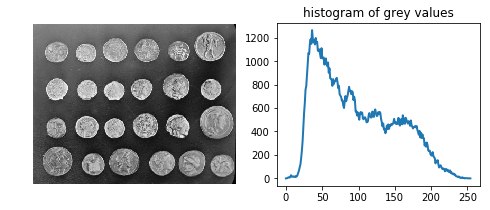

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2)
axes[1].set_title('histogram of grey values')
plt.show()

## Thresholding
A simple way to segment the coins is to choose a threshold based on the histogram of grey values. 
Unfortunately, thresholding this image gives a binary image that either misses significant parts of the coins or merges parts of the background with the coins:

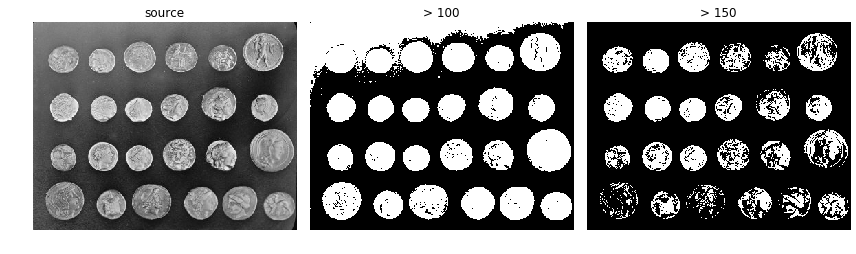

In [4]:
plot3(coins, coins > 100, coins >150, "source", "> 100", "> 150")

## Edge-based segmentation
Next, we try to delineate the contours of the coins using edge-based segmentation. To do this, we first get the edges of features using the Canny edge-detector.

These contours are then filled using mathematical morphology.

Small spurious objects are easily removed by setting a minimum size for valid objects.

However, this method is not very robust, since contours that are not perfectly closed are not filled correctly, as is the case for one unfilled coin above.

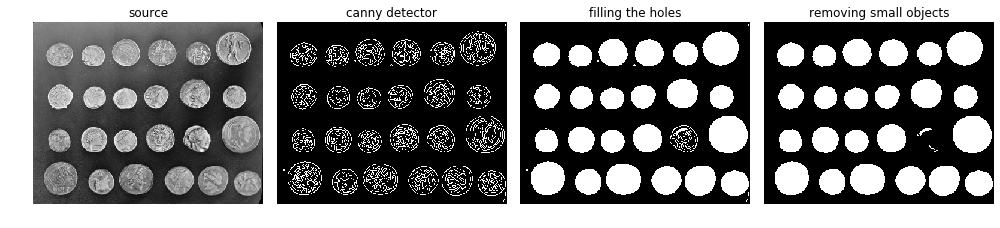

In [5]:
edges = canny(coins/255.)

fill_coins = ndi.binary_fill_holes(edges)

label_objects, nb_labels = ndi.label(fill_coins)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]
plot4(coins, edges, fill_coins, coins_cleaned, \
      "source", "canny detector", "filling the holes", "removing small objects")

## Region-based segmentation
We therefore try a region-based method using the watershed transform. First, we find an elevation map using the Sobel gradient of the image.

In [6]:
elevation_map = sobel(coins)

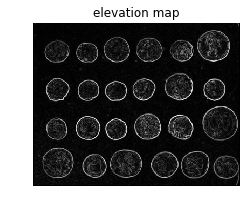

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off')
plt.show()

Next we find markers of the background and the coins based on the extreme parts of the histogram of grey values.



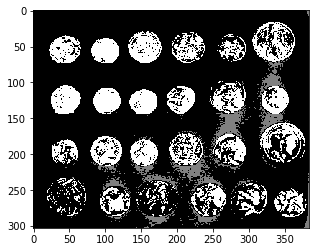

In [8]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

plt.imshow(markers, cmap='gray')
plt.show()

Finally, we use the watershed transform to fill regions of the elevation map starting from the markers determined above:


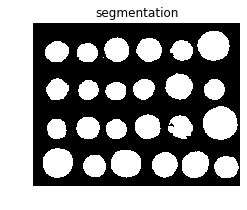

In [9]:
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')
plt.show()

This last method works even better, and the coins can be segmented and labeled individually.

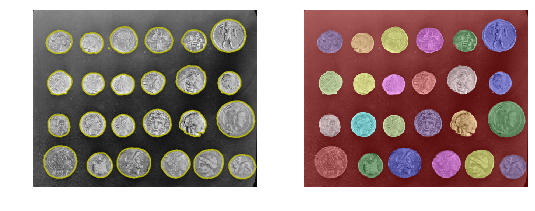

In [10]:
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')
    

plt.tight_layout()

# Image Segmentation using Python’s scikit-image module
https://habr.com/ru/post/441006/

https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

In [12]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

## Thresholding

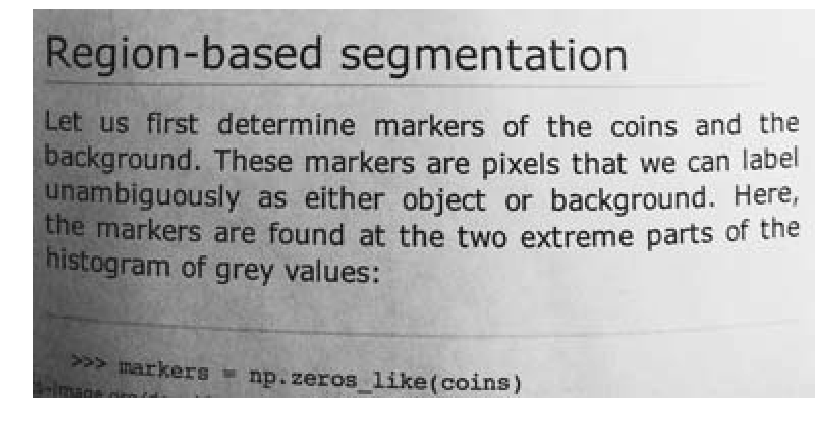

In [13]:
text = data.page()
image_show(text)
plt.show()

This image is a little darker but maybe we can still pick a value that will give us a reasonable segmentation without any advanced algorithms. Now to help us in picking that value, we will use a Histogram.

A histogram is a graph showing the number of pixels in an image at different intensity values found in that image. Simply put, a histogram is a graph wherein the x-axis shows all the values that are in the image while the y-axis shows the frequency of those values.

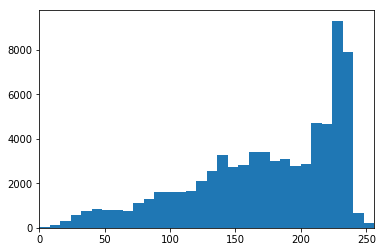

In [14]:
fig, ax = plt.subplots(1, 1)
ax.hist(text.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

Our example happens to be an 8-bit image so we have a total of 256 possible values on the x-axis. We observe that there is a concentration of pixels that are fairly light(0: black, 255: white). That’s most likely our fairly light text background but then the rest of it is kind of smeared out. An ideal segmentation histogram would be bimodal and fairly separated so that we could pick a number right in the middle. Now, let’s just try and make a few segmented images based on simple thresholding.

### Supervised thresholding
Since we will be choosing the thresholding value ourselves, we call it supervised thresholding.

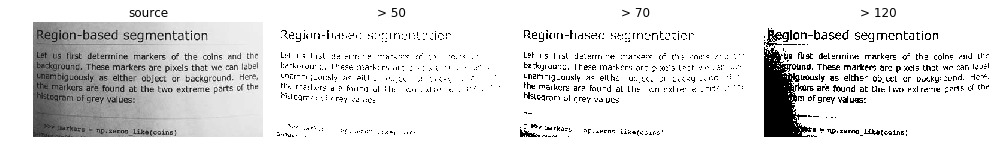

In [15]:
text_segmented50 = text > 50
text_segmented70 = text > 70
text_segmented120 = text > 120

plot4(text, text_segmented50, text_segmented70, text_segmented120,\
     "source", "> 50", "> 70", "> 120")
plt.show()

We didn’t get any ideal results since the shadow on the left creates problems. Let’s try with unsupervised thresholding now.
### Unsupervised thresholding
Scikit-image has a number of automatic thresholding methods, which require no input in choosing an optimal threshold. Some of the methods are : otsu, li, local.

In the case of local, we also need to specify the block_size . Offset helps to tune the image for better results.



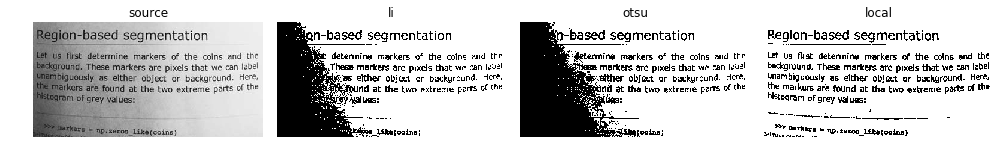

In [16]:
text_threshold_li = filters.threshold_li(text)
text_threshold_otsu = filters.threshold_otsu(text)
text_threshold_local = filters.threshold_local(text, block_size=51, offset=10)
plot4(text, text > text_threshold_li, text > text_threshold_otsu, text > text_threshold_local, \
     "source", "li", "otsu", "local")

## Supervised segmentation
Thresholding is a very basic segmentation process and will not work properly in a high-contrast image for which we will be needing more advanced tools.

For this section, we will use an example image which is freely available and attempt to segment the head portion using supervised segmentation techniques.

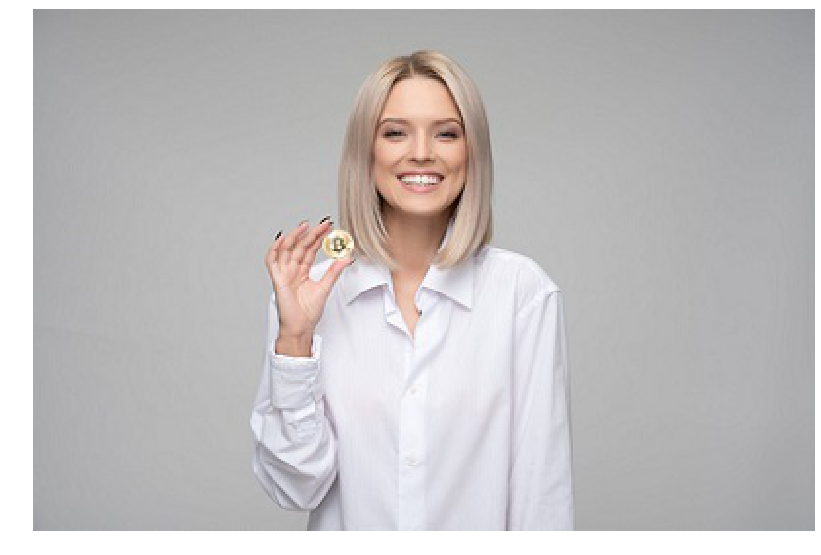

In [17]:
image = imread('images/girl.jpeg') 
image_show(image)
plt.show()

Before doing any segmentation on an image, it is a good idea to de-noise it using some filters.


However, in our case, the image is not very noisy, so we will take it as it is. Next step would be to convert the image to grayscale with rgb2gray.

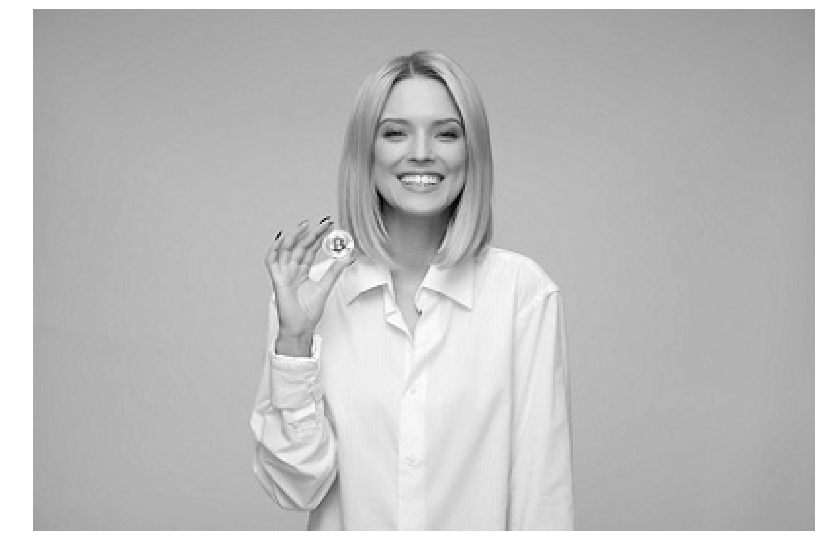

In [18]:
image_gray = color.rgb2gray(image) 
image_show(image_gray)
plt.show()

We will use two segmentation methods which work on entirely different principles.

### Active contour segmentation
Active Contour segmentation also called as __snakes__ and is initialized using a user-defined contour or line, around the area of interest and this contour then slowly contracts and is attracted or repelled from light and edges.

For our example image, let’s draw a circle around the person’s head to initialize the snake.

In [19]:
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [70, 200], 50)[:-1]

The above calculations calculate x and y co-ordinates of the points on the periphery of the circle. Since we have given the resolution to be 200, it will calculate 200 such points.


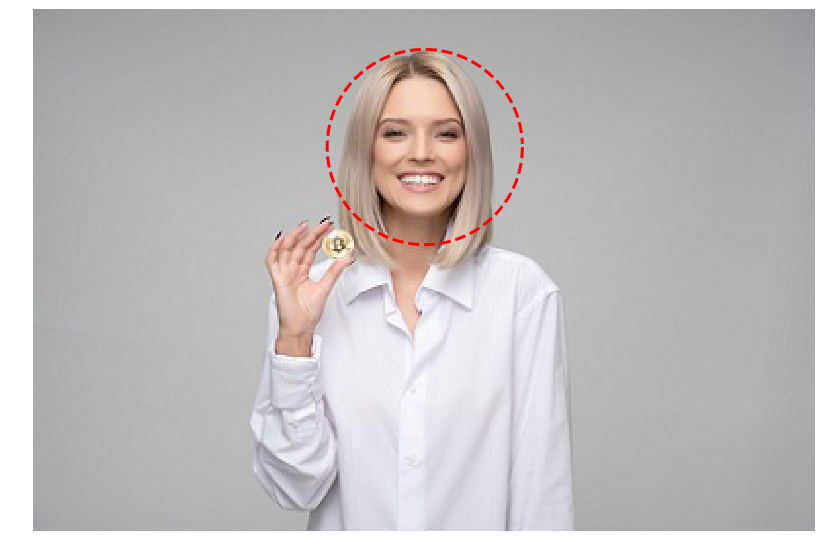

In [20]:
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
plt.show()

The algorithm then segments the face of a person from the rest of an image by fitting a closed curve to the edges of the face.

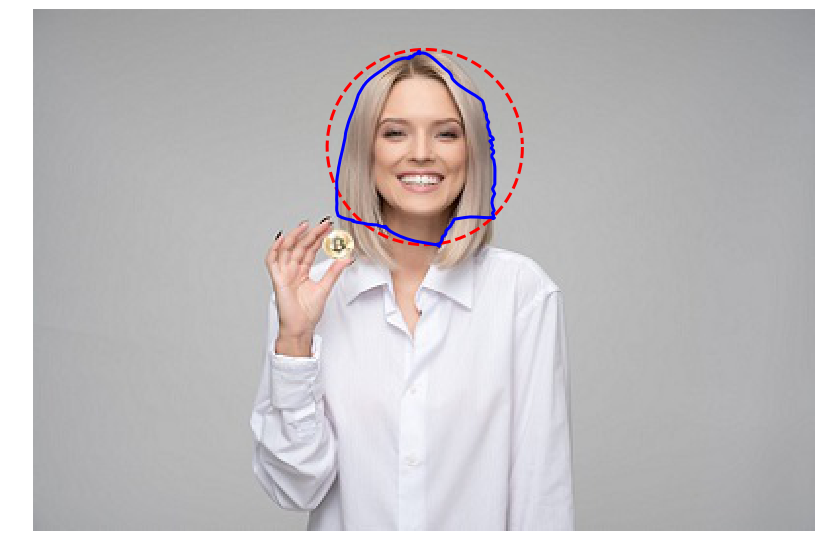

CPU times: user 2.08 s, sys: 130 ms, total: 2.21 s
Wall time: 1.3 s


In [21]:
%%time
snake = seg.active_contour(image_gray, points)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
plt.show()

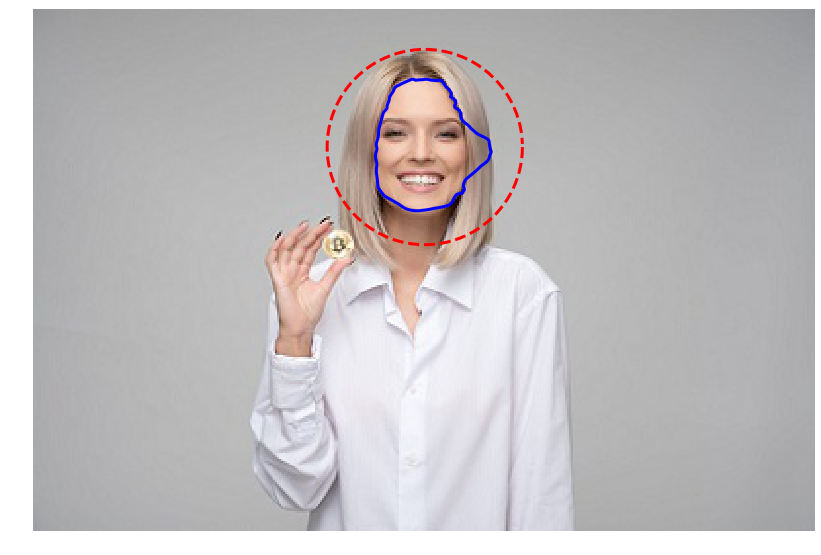

CPU times: user 939 ms, sys: 48.4 ms, total: 987 ms
Wall time: 409 ms


In [22]:
%%time
snake = seg.active_contour(image_gray, points,alpha=0.5,beta=0.9)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
plt.show()

### Random walker segmentation
In this method, a user interactively labels a small number of pixels which are known as __labels__. Each unlabeled pixel is then imagined to release a random walker and one can then determine the probability of a random walker starting at each unlabeled pixel and reaching one of the prelabeled pixels. By assigning each pixel to the label for which the greatest probability is calculated, high-quality image segmentation may be obtained. 

We will re-use the seed values from our previous example here. We could have
done different initializations but for simplicity let’s stick to circles.

In [23]:
image_labels = np.zeros(image_gray.shape, dtype=np.uint8)

The random walker algorithm expects a label image as input. So we will have the bigger circle that encompasses the person’s entire face and another smaller circle near the middle of the face.

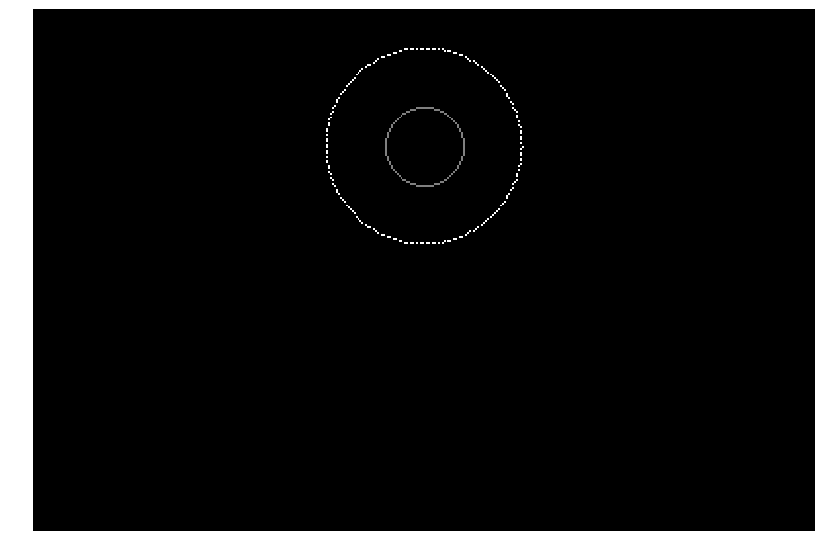

In [24]:
indices = draw.circle_perimeter(70, 200, 20)#from here
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
image_show(image_labels)
plt.show()

Now, let’s use Random Walker and see what happens.

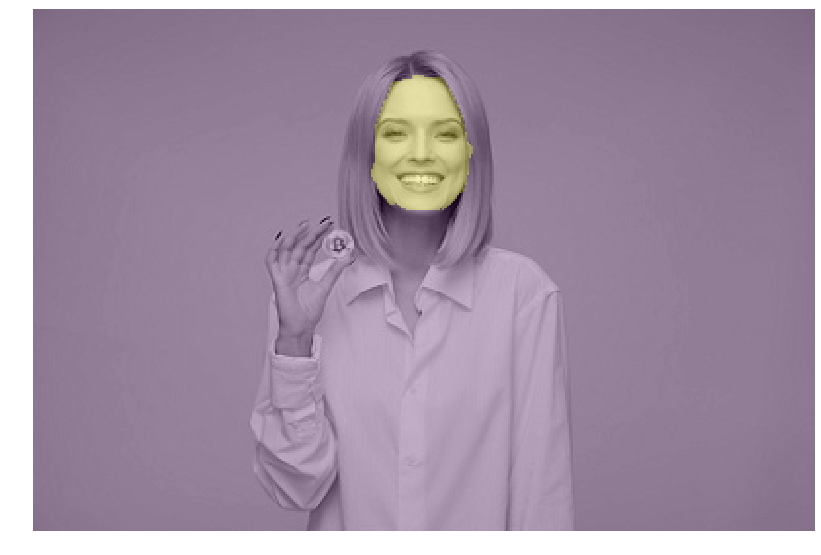

CPU times: user 3.24 s, sys: 266 ms, total: 3.5 s
Wall time: 1.93 s


In [25]:
%%time
image_segmented = seg.random_walker(image_gray, image_labels)
# Check our results
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3)
plt.show()

That’s all for Supervised Segmentation where we had to provide certain inputs and also had to tweak certain parameters. However, it is not always possible to have a human looking at an image and then deciding what inputs to give or where to start from. Fortunately, for those situations, we have Unsupervised segmentation techniques.

## Unsupervised segmentation
Unsupervised segmentation requires no prior knowledge. Consider an image that is so large that it is not feasible to consider all pixels simultaneously. So in such cases, Unsupervised segmentation can breakdown the image into several sub-regions, so instead of millions of pixels, you have tens to hundreds of regions. Let’s look at two such algorithms:
### SLIC( Simple Linear Iterative Clustering)
SLIC algorithm actually uses a machine learning algorithm called K-Means under the hood. It takes in all the pixel values of the image and tries to separate them out into the given number of sub-regions. Read the Reference Paper here.

SLIC works in color so we will use the original image.


In [26]:
image_slic = seg.slic(image,n_segments=155)

All we’re doing is just setting each sub-image or sub-region that we have found, to the average of that region which makes it look less like a patchwork of randomly assigned colors and more like an image that has been decomposed into areas that are kind of similar.

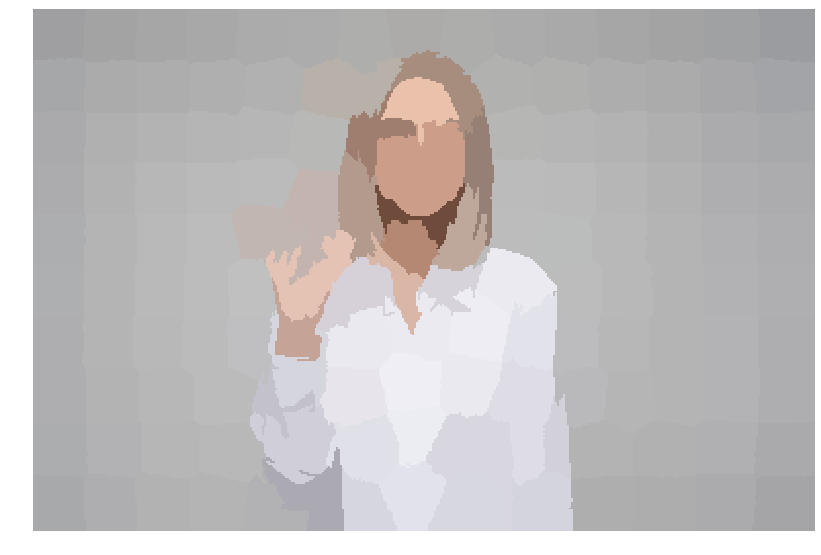

In [27]:
# label2rgb replaces each discrete label with the average interior color
image_show(color.label2rgb(image_slic, image, kind='avg'))
plt.show()



## Felzenszwalb
This algorithm also uses a machine learning algorithm called __minimum-spanning tree clustering__ under the hood. Felzenszwaib doesn’t tell us the exact number of clusters that the image will be partitioned into. It’s going to run and generate as many clusters as it thinks is appropriate for that
given scale or zoom factor on the image. 



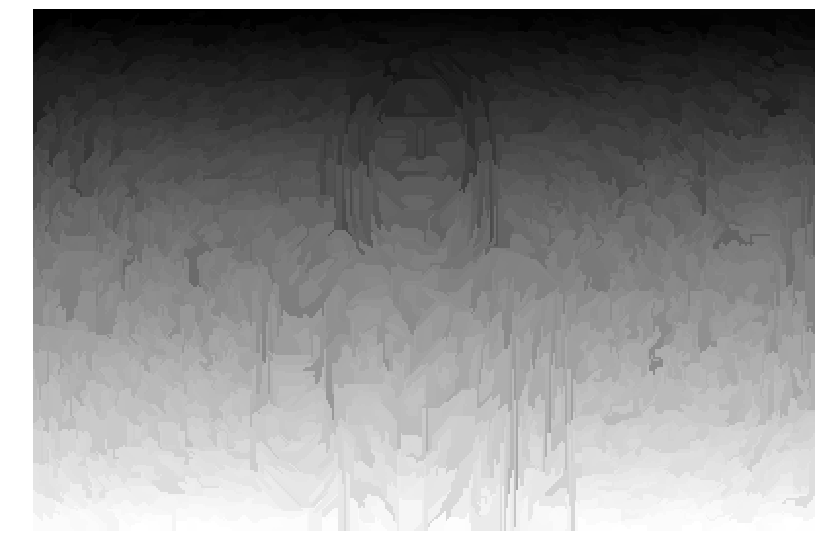

In [28]:
image_felzenszwalb = seg.felzenszwalb(image) 
image_show(image_felzenszwalb)
plt.show()

These are a lot of regions. Let’s calculate the number of unique regions.



In [29]:
np.unique(image_felzenszwalb).size

1724

Now let’s recolour them using the region average just as we did in the SLIC algorithm.

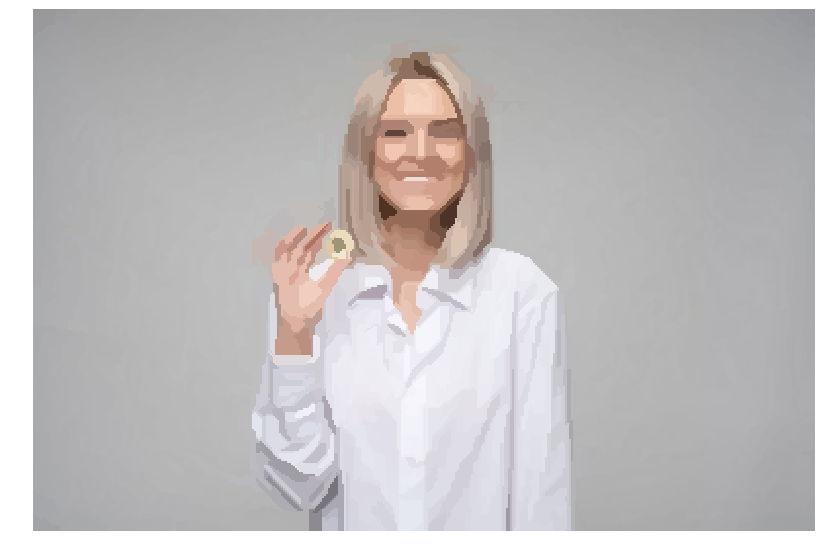

In [30]:
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind='avg')
image_show(image_felzenszwalb_colored)
plt.show()

Now we get reasonable smaller regions. If we wanted still fewer regions, we could change the `scale` parameter or start here and combine them. This approach is sometimes called __over-segmentation__.
This almost looks more like a posterized image which is essentially just a reduction in the number of colours. To combine them again, you can use the __Region Adjacency Graph(RAG)__ but that’s beyond the scope of this article.



https://habr.com/ru/post/441006/

## openCV
## A guide to finding books in images using Python and OpenCV.
https://pythontips.com/2015/03/11/a-guide-to-finding-books-in-images-using-python-and-opencv/
https://tproger.ru/translations/finding-books-python-opencv/

In [31]:
import cv2

In [32]:
# load the image, convert it to grayscale, and blur it
image = cv2.imread("images/books.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.convertScaleAbs(gray)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
#cv2.imwrite("images/books_gray.jpg", gray)

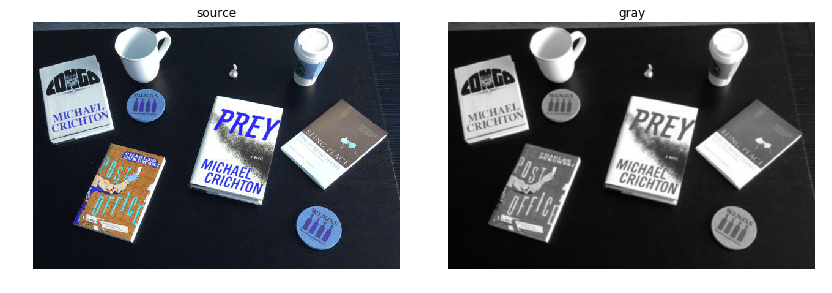

In [33]:
plot2(image, gray, "source", "gray")

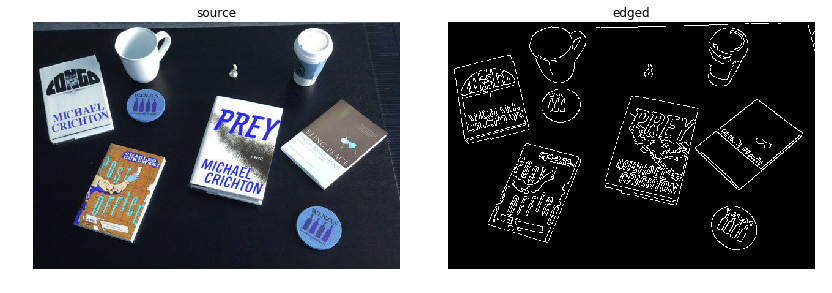

In [34]:
# detect edges in the image
edged = cv2.Canny(gray, 10, 250)
#cv2.imwrite("images/books_edged.jpg", edged)
plot2(image, edged, "source", "edged")

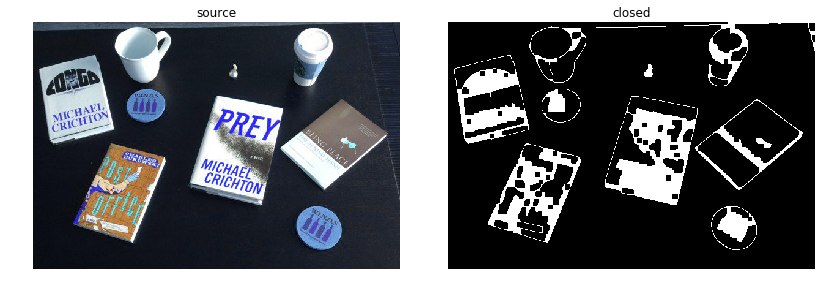

In [35]:
# construct and apply a closing kernel to 'close' gaps between 'white'
# pixels
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
#cv2.imwrite("images/books_closed.jpg", closed)
plot2(image, closed, "source", "closed")

In [36]:
# find contours (i.e. the 'outlines') in the image and initialize the
# total number of books found
(_, cnts, __) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#opencv 3.4.2
#(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)# opencv 4.1.0
total = 0

In [37]:
cv2.__version__

'3.4.2'

In [38]:
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if the approximated contour has four points, then assume that the
    # contour is a book - a book is a rectangle and thus has four vertices
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 4)
        total += 1

In [39]:
print("I find {0} books in this picture".format(total))
#cv2.imwrite("images/books_output.jpg", image)

I find 4 books in this picture


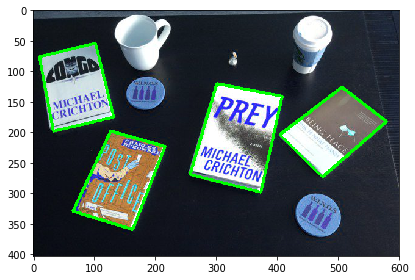

In [40]:
imshow(image)
plt.show()

## basic opencv
Основные операции с изображениями в OpenCV 3 Python
https://arboook.com/kompyuternoe-zrenie/osnovnye-operatsii-s-izobrazheniyami-v-opencv-3-python/

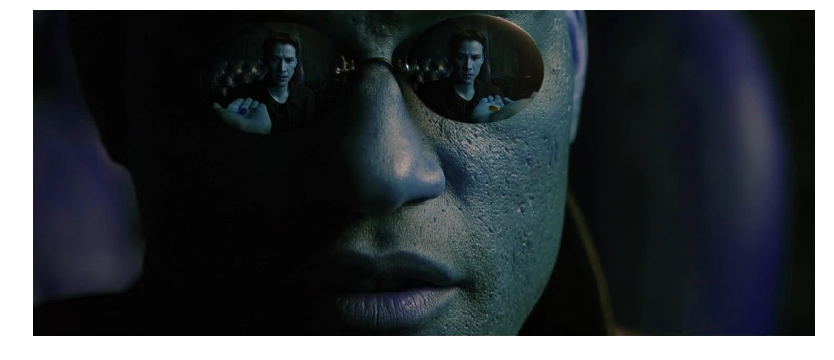

In [41]:
image = cv2.imread("images/matrix-sunglasses.jpg")
#cv2.imshow("Original image", image)
#cv2.waitKey(0)
image_show(image)
plt.show()

In [42]:
print(image.shape)

(667, 1600, 3)


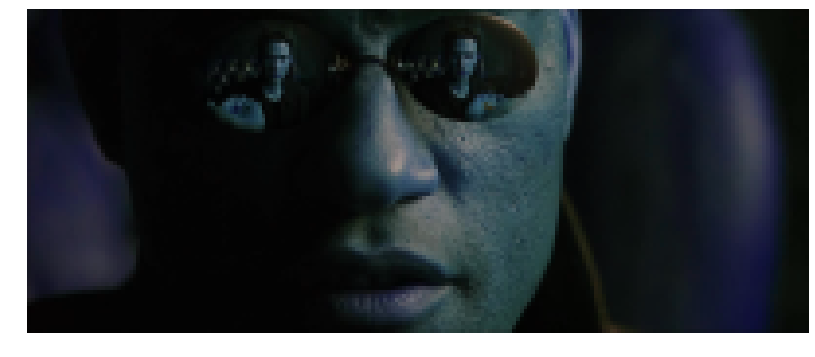

In [43]:
# Нам надо сохранить соотношение сторон
# чтобы изображение не исказилось при уменьшении
# для этого считаем коэф. уменьшения стороны
final_wide = 200
r = float(final_wide) / image.shape[1]
dim = (final_wide, int(image.shape[0] * r))
 
# уменьшаем изображение до подготовленных размеров
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
#cv2.imshow("Resize image", resized)
#cv2.waitKey(0)
image_show(resized)
plt.show()

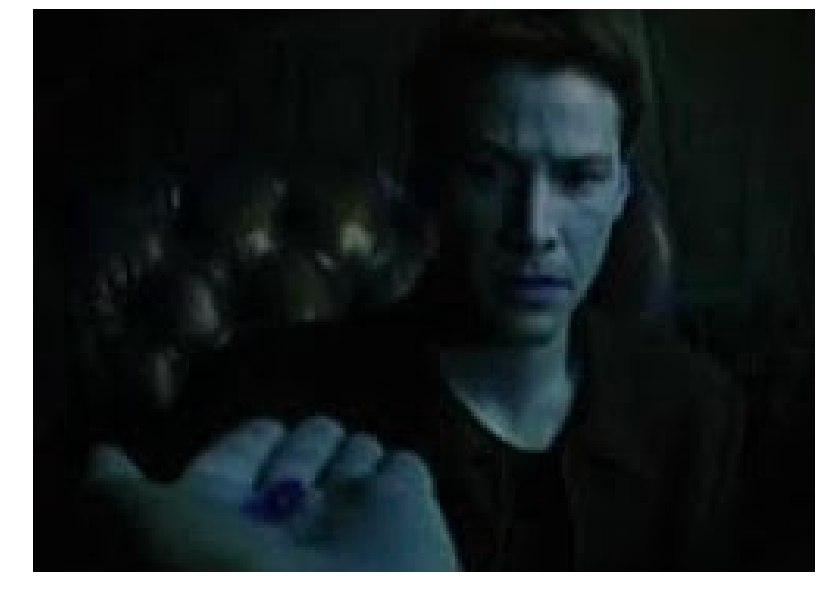

In [44]:
# вырежем участок изображения используя срезы
# мы же используем NumPy
cropped = image[50:230, 350:600]
#cv2.imshow("Cropped image", cropped)
#cv2.waitKey(0)
image_show(cropped)
plt.show()

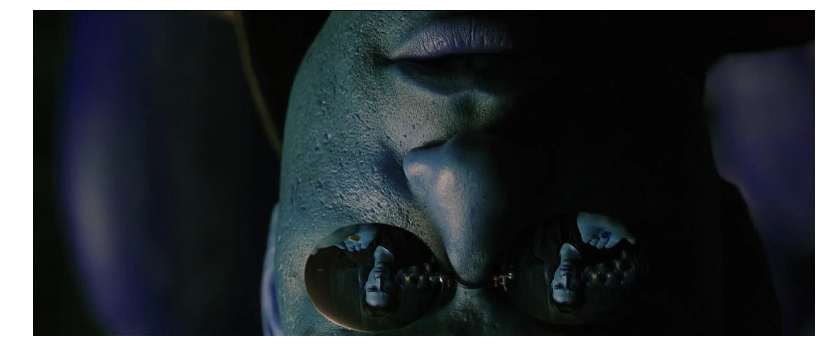

In [45]:
# получим размеры изображения для поворота
# и вычислим центр изображения
(h, w) = image.shape[:2]
center = (w / 2, h / 2)
 
# повернем изображение на 180 градусов
M = cv2.getRotationMatrix2D(center, 180, 1.0)
rotated = cv2.warpAffine(image, M, (w, h))
#cv2.imshow("Rotated image", rotated)
#cv2.waitKey(0)
image_show(rotated)
plt.show()

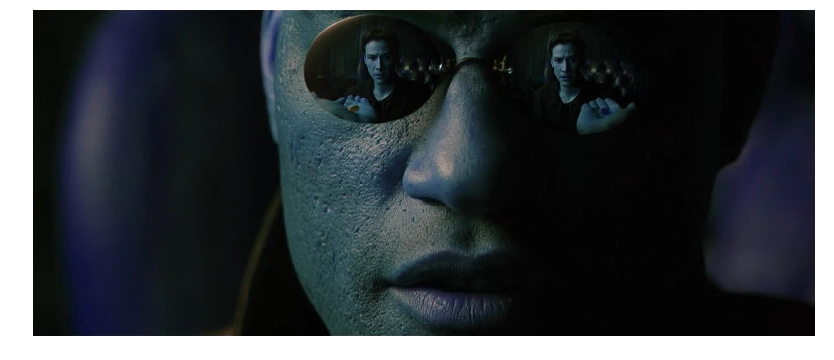

In [46]:
#отразим изображение по горизонтали
flip_image = cv2.flip(image,1)
#cv2.imshow("Flip image", flip_image)
#cv2.waitKey(0)
image_show(flip_image)
plt.show()

In [47]:
# запишем изображение на диск в формате png
cv2.imwrite("images/flip.png", flip_image)

True